In [82]:
# 1. Import necessary Python libraries and modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [83]:
# 2. Import the dataset
data = pd.read_csv('heart.csv')
print("\nDataset 'heart.csv' loaded successfully.")
print("Dataset shape:", data.shape)
print("\nFirst 5 rows of the dataset:")
print(data.head())


Dataset 'heart.csv' loaded successfully.
Dataset shape: (303, 14)

First 5 rows of the dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [84]:
# 3. Split dataset into feature data (X) and label data (y)
X = data.drop('target', axis=1)
y = data['target']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nUnique target values:", y.unique(), "(0=No Heart Disease, 1=Heart Disease)")
print("\nClass distribution:\n", y.value_counts(normalize=True)) # Check if data is imbalanced


Features (X) shape: (303, 13)
Target (y) shape: (303,)

Unique target values: [1 0] (0=No Heart Disease, 1=Heart Disease)

Class distribution:
 target
1    0.544554
0    0.455446
Name: proportion, dtype: float64


In [85]:
# 4. Split data into training and testing sets
# Stratify=y ensures that the proportion of target classes is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44652, stratify=y)

print(f"\nSplit data into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")


Split data into training (227 samples) and testing (76 samples) sets.
Training target distribution:
target
1    0.546256
0    0.453744
Name: proportion, dtype: float64
Testing target distribution:
target
1    0.539474
0    0.460526
Name: proportion, dtype: float64


In [86]:
# 5. Standardize the feature data
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the SAME fitted scaler
X_test_scaled = scaler.transform(X_test)

print("\nTraining and testing features standardized.")


Training and testing features standardized.


GridSearchCV found best parameters: {'C': 0.1, 'solver': 'liblinear'}

Logistic Regression model initialized with parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training the model...
Model training complete.

Evaluating the model on the test set...

--- Performance Metrics ---
Accuracy:  0.8289
Precision: 0.8043
Recall:    0.9024
F1 Score:  0.8506

--- Requirements Check ---
✅ All metrics (Accuracy, Precision, Recall, F1) are above 0.8.

--- Detailed Report ---
Classification Report:
                       precision    recall  f1-score   support

No Heart Disease (0)       0.87      0.74      0.80        35
   Heart Disease (1)       0.80      0.90      0.85        41

            accuracy                           0.83        76
           mac

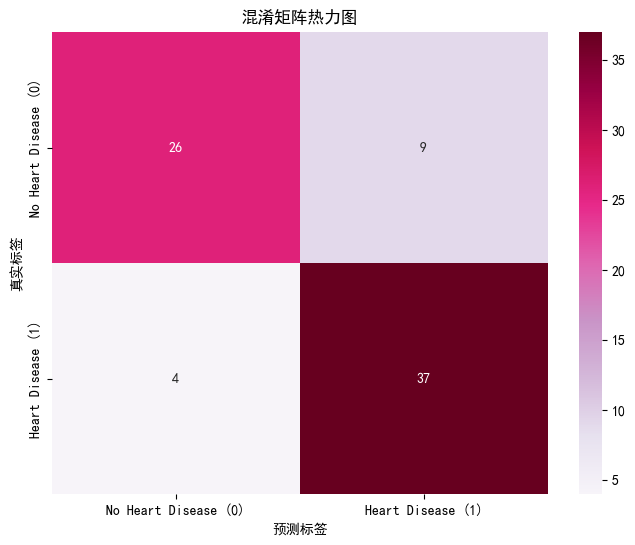

In [87]:
# 6. Build the Logistic Regression model
# We might need to tune parameters like 'C', 'solver', 'max_iter' to meet the metric requirements.
# Let's start with some common parameters. 'liblinear' solver is often good for smaller datasets.
# C is the inverse of regularization strength; smaller C means stronger regularization.
param_grid = {
    'C': [0.1, 0.3, 0.5, 1.0, 2.0, 5.0],
    'solver': ['liblinear', 'lbfgs','newton-cg','saga'],
}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)
print("GridSearchCV found best parameters:", grid_search.best_params_)

log_reg_model = LogisticRegression(solver=grid_search.best_params_['solver'], max_iter=10000,
                                    C=grid_search.best_params_['C'], random_state=42)

print(f"\nLogistic Regression model initialized with parameters: {log_reg_model.get_params()}")

# 7. Train the model
print("Training the model...")
log_reg_model.fit(X_train_scaled, y_train)
print("Model training complete.")

# 8. (Optional) View model parameters
# print(f"\nModel Coefficients (Weights): {log_reg_model.coef_}")
# print(f"Model Intercept (Bias): {log_reg_model.intercept_}")

# 9. Test the model and evaluate performance
print("\nEvaluating the model on the test set...")
# Predict class labels
y_pred = log_reg_model.predict(X_test_scaled)
# Predict probabilities (needed for ROC curve) - get probability of the positive class (1)
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) # Precision for class 1
recall = recall_score(y_test, y_pred)       # Recall for class 1
f1 = f1_score(y_test, y_pred)           # F1-score for class 1

print("\n--- Performance Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Check if requirements are met
print("\n--- Requirements Check ---")
if accuracy > 0.8 and precision > 0.8 and recall > 0.8 and f1 > 0.8:
    print("✅ All metrics (Accuracy, Precision, Recall, F1) are above 0.8.")
else:
    print("⚠️ Not all metrics meet the > 0.8 requirement. Consider tuning hyperparameters (e.g., C, solver, penalty) or trying different preprocessing/models.")
    if accuracy <= 0.8: print(f"   - Accuracy ({accuracy:.4f}) is not > 0.8")
    if precision <= 0.8: print(f"   - Precision ({precision:.4f}) is not > 0.8")
    if recall <= 0.8: print(f"   - Recall ({recall:.4f}) is not > 0.8")
    if f1 <= 0.8: print(f"   - F1 Score ({f1:.4f}) is not > 0.8")

# Display detailed classification report and confusion matrix
print("\n--- Detailed Report ---")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No Heart Disease (0)', 'Heart Disease (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='PuRd', 
        xticklabels=['No Heart Disease (0)', 'Heart Disease (1)'], 
        yticklabels=['No Heart Disease (0)', 'Heart Disease (1)'])
plt.title('混淆矩阵热力图')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()


Generating ROC Curve...
Area Under ROC Curve (AUC): 0.8843


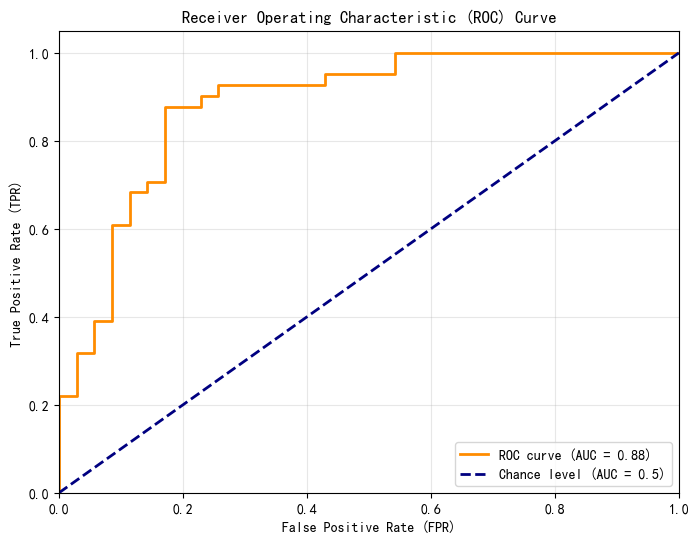

In [88]:
# 10. Visualize the results - ROC Curve
print("\nGenerating ROC Curve...")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)
print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level (AUC = 0.5)') # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) # Add a little space at the top
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()